This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce     

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(seqFile, labelFile, test_r=0.2 , valid_r=0.1):

   merged_set=[]
   #for h in hosp_list:
       #seqFile= folder+'h'+str(h)+'.visits'
       #labelFile= folder+'h'+str(h)+'.labels'
   set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
   set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
   merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       #merged_set_h_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       #merged_set_h =[x for x in merged_set_f if len(x[1])>0]

   merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [6]:
train1 , valid1, test1 = data_load_split_VT(seqFile = 'data2/cerner/unbalanced_data/hf50_all.visitsNN.train', labelFile = 'data2/cerner/unbalanced_data/hf50_all.labels.train')
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

20063 2865 5731


In [7]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[16072, 6419, 10916, 1139, 10010, 5703, 16078, 16064, 4778, 12240, 4695, 8354, 5483, 11849, 8283, 11781], [16072, 5703, 16078, 16064, 12240, 11849, 12686, 6102, 9982, 11781], [16072, 6419, 1139, 5703, 16078, 12047, 16064, 4778, 12240, 4695, 11849, 11842, 9982, 8283, 11781]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[1, [15488, 15379, 14018, 13996, 14510, 14994, 15645, 13839, 14290, 15097, 14873, 14722, 14991, 15006, 14217, 15130, 14725]]
[1, [16067, 16072, 7266, 16078, 7258, 7298]]
[0, [12252, 15091, 13871, 16066, 16071, 15379, 13872, 462, 16078, 9982, 1196, 15130, 15091, 3599, 16066, 11766, 16071, 13872, 16078, 5617, 14970, 9982, 15006, 1196, 250, 256, 467, 14701, 16066, 16071, 7266, 16078, 263, 7687, 15051, 8141, 16066, 16071, 1670, 16078, 14930, 5068, 9982, 189, 14886, 16066, 16071, 14429, 16078, 5736, 14893, 189, 5

In [8]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
-4.7267e-01
-3.7192e-01
-1.1843e+00
     ⋮      
-2.6146e+00
 2.6209e-01
 1.0586e+00
[torch.FloatTensor of size 20000x1]

        emb                           types
0 -0.472674                            Code
1 -0.371921  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -1.184314         b'M_BACITRACIN TOPICAL'
3 -0.663097    b'M_BUPIVACAINE-EPINEPHRINE'
4 -1.187897                  b'M_CEFAZOLIN'


In [9]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 1.0181314910602168


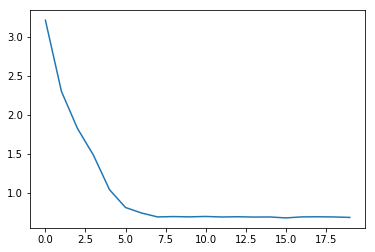

Epoch  0 Summary:  Training_auc : 0.580622477667309  , Validation_auc :  0.5869412703071386  ,Test_auc :  0.5835653705061645 Test_auc on short visits: 0.5715696751902243 Test_auc on long visits: 0.5885937281797445  Avg Loss:  1.0181314910602168 Train Time (0m 27s) Eval Time (0m 16s)

 Current running on: Epoch  1 Training loss:  Average loss 0.6804517292307224


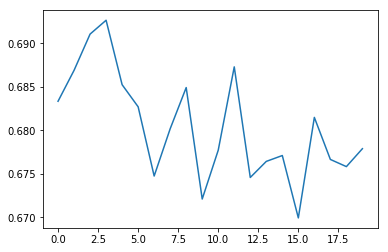

Epoch  1 Summary:  Training_auc : 0.6246529729666486  , Validation_auc :  0.628897980913898  ,Test_auc :  0.6274506751604115 Test_auc on short visits: 0.6097062563560637 Test_auc on long visits: 0.6416404177075737  Avg Loss:  0.6804517292307224 Train Time (1m 11s) Eval Time (0m 23s)

 Current running on: Epoch  2 Training loss:  Average loss 0.6681646467020147


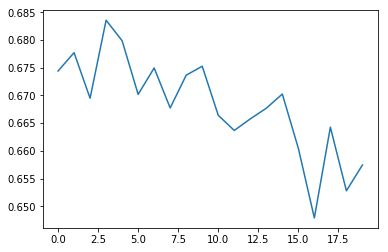

Epoch  2 Summary:  Training_auc : 0.6678112755955725  , Validation_auc :  0.6769681628529891  ,Test_auc :  0.6703554533558278 Test_auc on short visits: 0.653055008697562 Test_auc on long visits: 0.6893459742113675  Avg Loss:  0.6681646467020147 Train Time (0m 28s) Eval Time (0m 16s)

 Current running on: Epoch  3 Training loss:  Average loss 0.6517509431543311


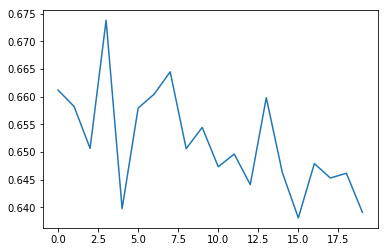

Epoch  3 Summary:  Training_auc : 0.7093822841700833  , Validation_auc :  0.7173296521032838  ,Test_auc :  0.7107317528189373 Test_auc on short visits: 0.6931893235636291 Test_auc on long visits: 0.7299511226278959  Avg Loss:  0.6517509431543311 Train Time (0m 33s) Eval Time (0m 17s)

 Current running on: Epoch  4 Training loss:  Average loss 0.6351131184566655


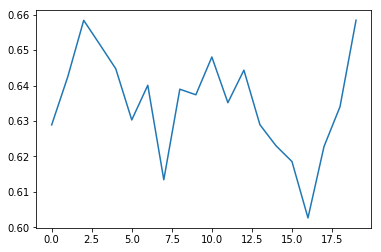

Epoch  4 Summary:  Training_auc : 0.7390845110429121  , Validation_auc :  0.7454444534367952  ,Test_auc :  0.7347168633702127 Test_auc on short visits: 0.71589469504422 Test_auc on long visits: 0.7511995903610719  Avg Loss:  0.6351131184566655 Train Time (0m 33s) Eval Time (0m 18s)

 Current running on: Epoch  5 Training loss:  Average loss 0.6209667598003923


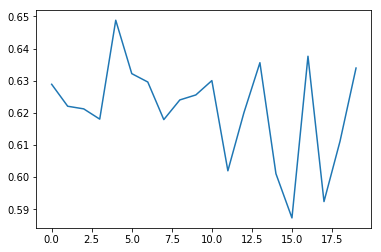

Epoch  5 Summary:  Training_auc : 0.7578077836610775  , Validation_auc :  0.7604679088461654  ,Test_auc :  0.746802025957396 Test_auc on short visits: 0.7274199593530224 Test_auc on long visits: 0.762309494623489  Avg Loss:  0.6209667598003923 Train Time (0m 32s) Eval Time (0m 19s)

 Current running on: Epoch  6 Training loss:  Average loss 0.6096054855136263


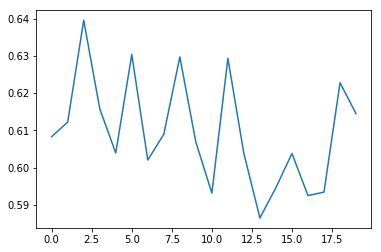

Epoch  6 Summary:  Training_auc : 0.7699457879607197  , Validation_auc :  0.7678799352160717  ,Test_auc :  0.7546272522134796 Test_auc on short visits: 0.7331404166872235 Test_auc on long visits: 0.7712092106692321  Avg Loss:  0.6096054855136263 Train Time (0m 34s) Eval Time (0m 18s)

 Current running on: Epoch  7 Training loss:  Average loss 0.601292429545119


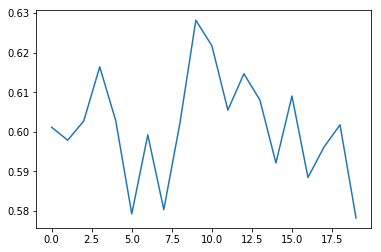

Epoch  7 Summary:  Training_auc : 0.7774014630865274  , Validation_auc :  0.7713000078981009  ,Test_auc :  0.757940725948532 Test_auc on short visits: 0.7369707656878396 Test_auc on long visits: 0.7755327633559358  Avg Loss:  0.601292429545119 Train Time (0m 32s) Eval Time (0m 18s)

 Current running on: Epoch  8 Training loss:  Average loss 0.5953198569565987


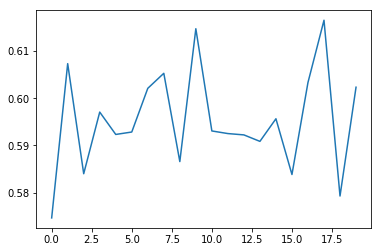

Epoch  8 Summary:  Training_auc : 0.7830523817434765  , Validation_auc :  0.7735821690135076  ,Test_auc :  0.7590272288693557 Test_auc on short visits: 0.7359404666604068 Test_auc on long visits: 0.7778500162924574  Avg Loss:  0.5953198569565987 Train Time (0m 33s) Eval Time (0m 18s)

 Current running on: Epoch  9 Training loss:  Average loss 0.5914792788600154


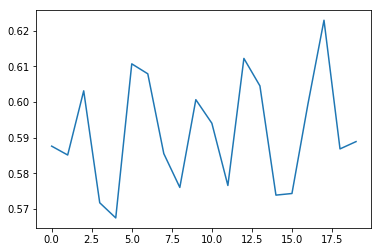

Epoch  9 Summary:  Training_auc : 0.7863784100509291  , Validation_auc :  0.7740350909695455  ,Test_auc :  0.7601567084199277 Test_auc on short visits: 0.7366711653141547 Test_auc on long visits: 0.7795000543081912  Avg Loss:  0.5914792788600154 Train Time (0m 32s) Eval Time (0m 17s)

 Current running on: Epoch  10 Training loss:  Average loss 0.5884941288630409


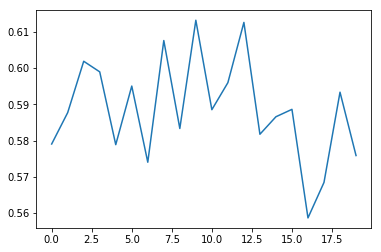

Epoch  10 Summary:  Training_auc : 0.7885855080519943  , Validation_auc :  0.7724349942421871  ,Test_auc :  0.7583167104124804 Test_auc on short visits: 0.736985089211681 Test_auc on long visits: 0.777164181420392  Avg Loss:  0.5884941288630409 Train Time (0m 34s) Eval Time (0m 17s)

 Current running on: Epoch  11 Training loss:  Average loss 0.5855281526841944


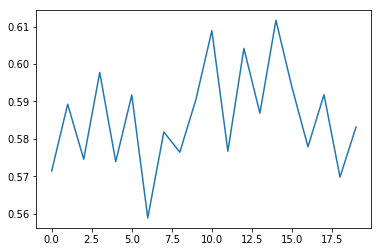

Epoch  11 Summary:  Training_auc : 0.7899895645898541  , Validation_auc :  0.7721210203566237  ,Test_auc :  0.7563495528599116 Test_auc on short visits: 0.734632848296376 Test_auc on long visits: 0.7756134498114731  Avg Loss:  0.5855281526841944 Train Time (0m 32s) Eval Time (0m 16s)

 Current running on: Epoch  12 Training loss:  Average loss 0.5837791575423331


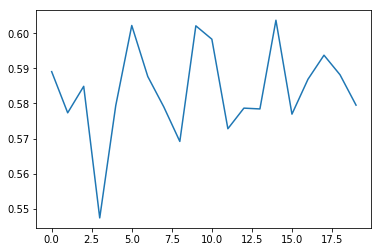

Epoch  12 Summary:  Training_auc : 0.7921989459089618  , Validation_auc :  0.7723998915717513  ,Test_auc :  0.7580824145247334 Test_auc on short visits: 0.7344621596372647 Test_auc on long visits: 0.7784939562741477  Avg Loss:  0.5837791575423331 Train Time (0m 34s) Eval Time (0m 16s)

 Current running on: Epoch  13 Training loss:  Average loss 0.5824609474892888


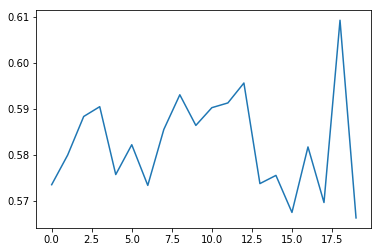

Epoch  13 Summary:  Training_auc : 0.7937075425964173  , Validation_auc :  0.7717955893494597  ,Test_auc :  0.7603597485769487 Test_auc on short visits: 0.7361161287652964 Test_auc on long visits: 0.7813452914798206  Avg Loss:  0.5824609474892888 Train Time (0m 34s) Eval Time (0m 17s)

 Current running on: Epoch  14 Training loss:  Average loss 0.5819078797533467


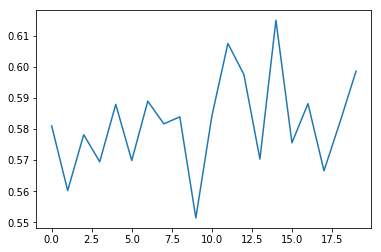

Epoch  14 Summary:  Training_auc : 0.794564940957773  , Validation_auc :  0.7707929693251414  ,Test_auc :  0.7567222408210099 Test_auc on short visits: 0.7342377577637478 Test_auc on long visits: 0.7776504724812637  Avg Loss:  0.5819078797533467 Train Time (0m 33s) Eval Time (0m 16s)

 Current running on: Epoch  15 Training loss:  Average loss 0.5795930655649337


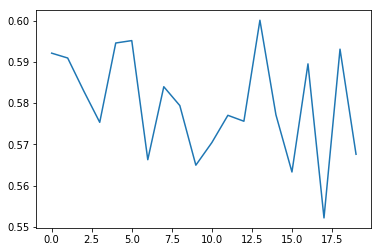

Epoch  15 Summary:  Training_auc : 0.7951807155196441  , Validation_auc :  0.7700765335722914  ,Test_auc :  0.757519811371665 Test_auc on short visits: 0.7333664100633897 Test_auc on long visits: 0.778932766459261  Avg Loss:  0.5795930655649337 Train Time (0m 32s) Eval Time (0m 16s)

 Current running on: Epoch  16 Training loss:  Average loss 0.5800860106541951


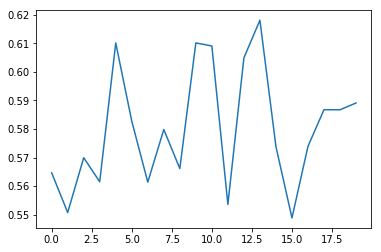

Epoch  16 Summary:  Training_auc : 0.7970556628764781  , Validation_auc :  0.7702557034526402  ,Test_auc :  0.7591438884424366 Test_auc on short visits: 0.7347012829102855 Test_auc on long visits: 0.781384393377504  Avg Loss:  0.5800860106541951 Train Time (0m 31s) Eval Time (0m 17s)

 Current running on: Epoch  17 Training loss:  Average loss 0.5782197271763226


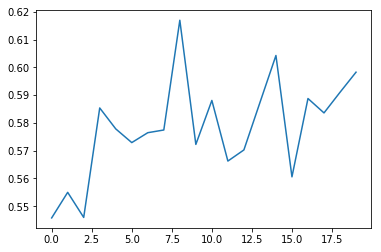

Epoch  17 Summary:  Training_auc : 0.7975117693354903  , Validation_auc :  0.7698700616149374  ,Test_auc :  0.7581176382681494 Test_auc on short visits: 0.7333755612036217 Test_auc on long visits: 0.7797961115335081  Avg Loss:  0.5782197271763226 Train Time (0m 33s) Eval Time (0m 17s)

 Current running on: Epoch  18 Training loss:  Average loss 0.5779455367425383


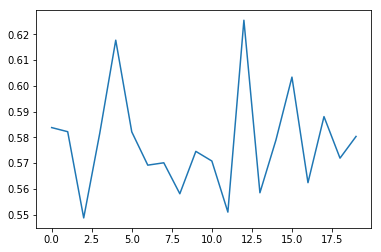

Epoch  18 Summary:  Training_auc : 0.7981592118770107  , Validation_auc :  0.7685858889214997  ,Test_auc :  0.758489105302266 Test_auc on short visits: 0.7328650867289369 Test_auc on long visits: 0.7813977376759197  Avg Loss:  0.5779455367425383 Train Time (0m 34s) Eval Time (0m 17s)

 Current running on: Epoch  19 Training loss:  Average loss 0.5770361805207993


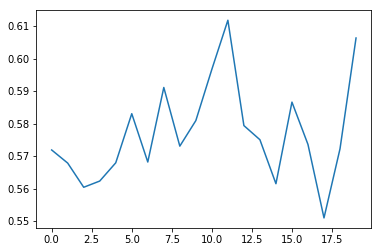

Epoch  19 Summary:  Training_auc : 0.7976777352175254  , Validation_auc :  0.7669989556955545  ,Test_auc :  0.7560370565990004 Test_auc on short visits: 0.7325209242810784 Test_auc on long visits: 0.7794342638136764  Avg Loss:  0.5770361805207993 Train Time (0m 32s) Eval Time (0m 17s)


In [11]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [12]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

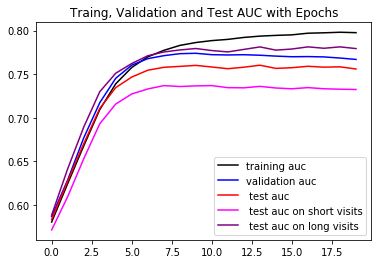

In [13]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [17]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim1_hf50_balanced')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')